In [5]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.1 MB/s 
     |████████████████████████████████| 212 kB 70.2 MB/s 


In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nlp
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [11]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

### Import Data

In [12]:
dataset = nlp.load_dataset('emotion')
train = dataset['train']
val = dataset['validation']
test = dataset['test']
def gt(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels
tweets, labels = gt(train)
tweets[2],labels[2]

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


('im grabbing a minute to post i feel greedy wrong', 'anger')

### Tokenizer

In [13]:
tokenizer = Tokenizer(num_words=10000, oov_token ='<UNK>')
tokenizer.fit_on_texts(tweets)
tokenizer.texts_to_sequences([tweets[1]])
tweets[2]

'im grabbing a minute to post i feel greedy wrong'

### Padding and Truncating Sequences

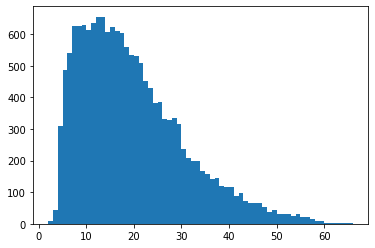

In [14]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins = len(set(lengths)))
plt.show()

In [15]:
maxlen = 50
def gs(tokenizer,tweets):
  seq = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(seq,truncating='post',padding = 'post',maxlen=maxlen)
  return padded
padded_train_seq = gs(tokenizer,tweets)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Preparing Labels

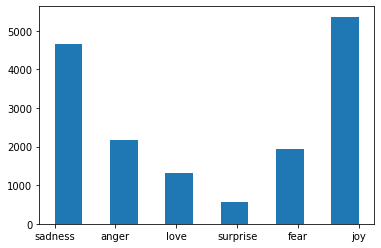

In [16]:
classes = set(labels)
plt.hist(labels, bins=11)
plt.show()

In [17]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())
print(class_to_index)
print(index_to_class)
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)

{'sadness': 0, 'surprise': 1, 'fear': 2, 'love': 3, 'joy': 4, 'anger': 5}
{0: 'sadness', 1: 'surprise', 2: 'fear', 3: 'love', 4: 'joy', 5: 'anger'}


### Creating and Training RNN Model

In [18]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000,16,input_length= maxlen),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6,activation='softmax')
])
model.compile(
    
       loss = 'sparse_categorical_crossentropy',
       optimizer = 'adam',
       metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [19]:
vt, vl = gt(val)
vs = gs(tokenizer,vt)
vl = names_to_ids(vl)
h = model.fit(
    
       padded_train_seq, train_labels,
       validation_data = (vs,vl),
       epochs = 20,
       callbacks = [
                    tf.keras.callbacks.EarlyStopping(monitor ='val_accuracy',patience = 2)
       ]
)

Epoch 1/20
500/500 [==============================] - 34s 54ms/step - loss: 1.2812 - accuracy: 0.4866 - val_loss: 0.7924 - val_accuracy: 0.7125
Epoch 2/20
500/500 [==============================] - 24s 48ms/step - loss: 0.5326 - accuracy: 0.8102 - val_loss: 0.4948 - val_accuracy: 0.8330
Epoch 3/20
500/500 [==============================] - 23s 46ms/step - loss: 0.3265 - accuracy: 0.8912 - val_loss: 0.4455 - val_accuracy: 0.8610
Epoch 4/20
500/500 [==============================] - 24s 48ms/step - loss: 0.2194 - accuracy: 0.9308 - val_loss: 0.4111 - val_accuracy: 0.8695
Epoch 5/20
500/500 [==============================] - 23s 47ms/step - loss: 0.1748 - accuracy: 0.9466 - val_loss: 0.3991 - val_accuracy: 0.8720
Epoch 6/20
500/500 [==============================] - 24s 48ms/step - loss: 0.1375 - accuracy: 0.9575 - val_loss: 0.3768 - val_accuracy: 0.8810
Epoch 7/20
500/500 [==============================] - 25s 50ms/step - loss: 0.1107 - accuracy: 0.9663 - val_loss: 0.3856 - val_accuracy:

### Model Evaluation

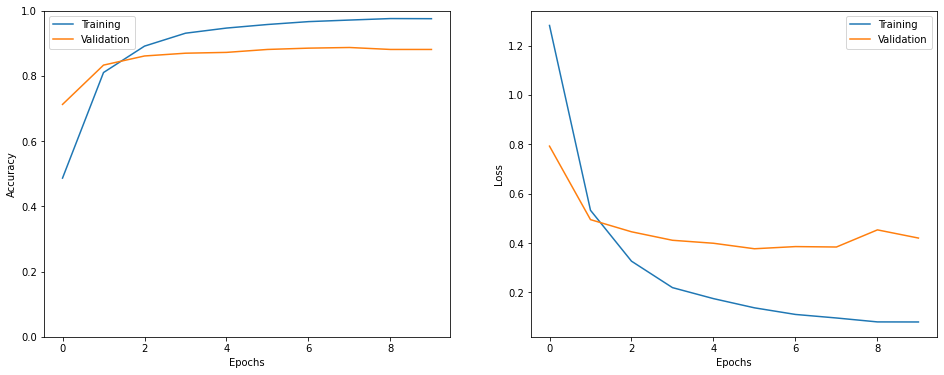

In [20]:
show_history(h)